In [0]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.util import *
from autograd import (grad, elementwise_grad, jacobian, value_and_grad,
                      grad_and_aux, hessian_vector_product, hessian,
                      jacobian, vector_jacobian_product)

In [0]:
def test_jacobian_against_stacked_grads():
    scalar_funs = [
        lambda x: np.sum(x**3),
        lambda x: np.prod(np.sin(x) + np.sin(x)),
        lambda x: grad(lambda y: np.exp(y) * np.tanh(x[0]))(x[1])
    ]
 
    vector_fun = lambda x: np.array([f(x) for f in scalar_funs])
 
    x = npr.randn(5)
    jac = jacobian(vector_fun)(x)
    grads = [grad(f)(x) for f in scalar_funs]
 
    assert np.allclose(jac, np.vstack(grads))


In [0]:
test_jacobian_against_stacked_grads()

In [0]:

from __future__ import division
import autograd.numpy as np
import autograd.numpy.random as npr
#from autograd.util import check_grads
from autograd import grad, jacobian
 
npr.seed(1)
 
 
def test_jacobian_against_grad():
    fun = lambda x: np.sum(np.sin(x), axis=1, keepdims=True)
    A = npr.randn(1,3)
    assert np.allclose(grad(fun)(A), jacobian(fun)(A))
 
def test_jacobian_scalar_to_vector():
    fun = lambda x: np.array([x, x**2, x**3])
    val = npr.randn()
    assert np.allclose(jacobian(fun)(val), np.array([1., 2*val, 3*val**2]))
 
def test_jacobian_against_stacked_grads():
    scalar_funs = [
        lambda x: np.sum(x**3),
        lambda x: np.prod(np.sin(x) + np.sin(x)),
        lambda x: grad(lambda y: np.exp(y) * np.tanh(x[0]))(x[1])
    ]
 
    vector_fun = lambda x: np.array([f(x) for f in scalar_funs])
 
    x = npr.randn(5)
    jac = jacobian(vector_fun)(x)
    grads = [grad(f)(x) for f in scalar_funs]
 
    assert np.allclose(jac, np.vstack(grads))
 
def test_jacobian_higher_order():
    fun = lambda x: np.sin(np.outer(x,x)) + np.cos(np.dot(x,x))

In [0]:
test_jacobian_scalar_to_vector()

In [0]:
test_jacobian_against_grad()

In [0]:
test_jacobian_against_stacked_grads()


In [0]:
test_jacobian_higher_order()

## Solving differential algebraic equations with help from autograd

In [0]:
import autograd.numpy as np
from autograd import grad
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
%matplotlib inline
import matplotlib.pyplot as plt

P = 760 * 1.2 # mmHg
A1, B1, C1 = 6.90565, -1211.033,  220.79
A2, B2, C2 = 6.95464, -1344.8, 219.482

def k1(T):
    return 10**(A1 + B1 / (C1 + T)) / P

def k2(T):
    return 10**(A2 + B2 / (C2 + T)) / P

def f(x2, T):
    x1 = 1 - x2
    return k1(T) * x1 + k2(T) * x2 - 1

T0, = fsolve(lambda T: f(0.4, T), 96)
print(f'The initial temperature is {T0:1.2f} degC.')

The initial temperature is 95.59 degC.


At x2=0.80 there are 14.04 moles of liquid left at 108.57 degC


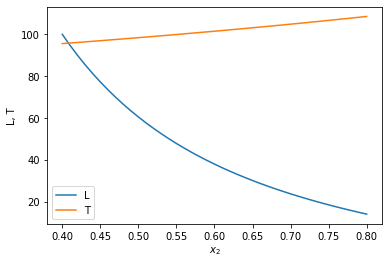

In [0]:
dfdx2 = grad(f, 0)
dfdT  = grad(f, 1)

def dTdx2(x2, T):
    return -dfdx2(x2, T) / dfdT(x2, T)

def ode(x2, X):
    L, T = X
    dLdx2 = L / (x2 * (k2(T) - 1))
    return [dLdx2, dTdx2(x2, T)]
# Next we solve and plot the ODE.

x2span = (0.4, 0.8)
X0 = (100, T0)
sol = solve_ivp(ode, x2span, X0, max_step=0.01)

plt.plot(sol.t, sol.y.T)
plt.legend(['L', 'T']);
plt.xlabel('$x_2$')
plt.ylabel('L, T')
x2 = sol.t
L, T = sol.y
print(f'At x2={x2[-1]:1.2f} there are {L[-1]:1.2f} moles of liquid left at {T[-1]:1.2f} degC')
# At x2=0.80 there are 14.04 moles of liquid left at 108.57 degC

True


array([ 2.22044605e-16,  4.44089210e-16,  2.22044605e-16,  0.00000000e+00,
        1.11022302e-15,  0.00000000e+00,  6.66133815e-16,  0.00000000e+00,
       -2.22044605e-16,  1.33226763e-15,  8.88178420e-16, -4.44089210e-16,
        4.44089210e-16,  1.11022302e-15, -2.22044605e-16,  0.00000000e+00,
       -2.22044605e-16, -1.11022302e-15,  4.44089210e-16,  0.00000000e+00,
       -4.44089210e-16,  4.44089210e-16, -6.66133815e-16, -4.44089210e-16,
        4.44089210e-16, -1.11022302e-16, -8.88178420e-16, -8.88178420e-16,
       -9.99200722e-16, -3.33066907e-16, -7.77156117e-16, -2.22044605e-16,
       -9.99200722e-16, -1.11022302e-15, -3.33066907e-16, -1.99840144e-15,
       -1.33226763e-15, -2.44249065e-15, -1.55431223e-15, -6.66133815e-16,
       -2.22044605e-16])

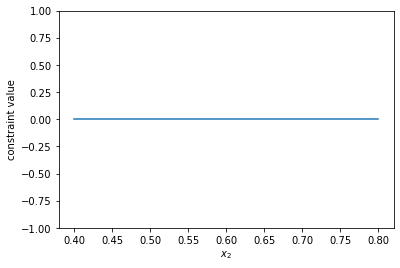

In [0]:
constraint = k1(T) * (1 - x2) + k2(T) * x2 - 1
plt.plot(x2, constraint)
plt.ylim([-1, 1])
plt.xlabel('$x_2$')
plt.ylabel('constraint value')
print(np.allclose(constraint, np.zeros_like(constraint)))
constraint